# THIS WORK IS CURRENTLY WRONG

And it's a mess. I'll fix it later.

In [1]:
from functools import partial
import time
from typing import Callable, Generator

import matplotlib.pyplot as plt
import numpy as np

# Problem

Say you're hosting an application which ingests a request from a stream, processes it,
and returns back the processed result. Assume that the application runs faster *per
input* as the number of inputs increases, e.g., database operations, matrix
multiplications. Let's refer to this property as a "batch effect"—the application's
favorable scaling wrt batch size.

Define latency as the time between a user submitting a request and receiving a response.

The simplest way to try to minimize latency (average, 95th percentile, your favorite
statistic) is to process each request immediately. Here, we're not exploiting the batch
effect, but we *are* always doing something if there's something to do.

In which situations is it faster to *wait* until multiple requests have been received
before processing them? It seems risky b/c the application is doing nothing while it
waits for a request—a request which could come at any time in the future. But if the
batch effect is sufficiently strong, perhaps that uncertainty is ok.

To batch, or not to batch, that is the question.

Now, in Shakespeare:

<span style="font-family: Baskerville;">
Hark! Pray, lend thine ear and hearken to my words,<br>
As I unfold a tale of applications and streams.<br>
Imagine, if thou wilt, a realm where requests flow like a ceaseless river.<br>

In this realm, an application doth exist,<br>
Which doth receive these requests, and process them too.<br>
With each input it receives, its speed doth soar,<br>
Like a mighty eagle soaring through the skies.<br>

This property, this wondrous scaling power,<br>
A "batch effect" it is called, a name so apt.<br>
For as the number of inputs doth increase,<br>
Faster doth it run, with greater strength and might.<br>

But what of latency, that measure of time,<br>
Betwixt a request made and response received?<br>
To minimize this span, one method is simple,<br>
To process each request as soon as it arrives.<br>

Yet, in doing so, we fail to grasp the batch effect,<br>
Though we toil ceaselessly, always in motion.<br>
For there are moments, rare and fleeting, where we ponder,<br>
Might it be faster to await a gathering of requests?<br>

Ah, the risk! The perilous gamble we undertake,<br>
To pause and wait, idle in anticipation.<br>
For the request, it might come at any future moment,<br>
Leaving us in anxious suspense, our fate uncertain.<br>

But if the batch effect be potent, strong and true,<br>
Perhaps uncertainty shall be deemed worthwhile.<br>

Like sailors upon a tempestuous sea we sail,<br>
Deliberating the value of setting sail or anchoring still.<br>
In this boundless wave of requests, we must decide,<br>
To seize the moment, or await the gathering storm.<br>
To batch or not to batch, that is the question.<br>

# Formalization

I want to understand what conditions are required for waiting and batching to result in
a significant speedup over not batching. That's why I think it's helpful to do some
basic theory. In a work setting, you should instead do the hard but simple work of
evaluating a range of reasonable batch sizes.

Assume the following:

* Requests arrive at times $T_i$ s.t. $T_{i+1} - T_i \sim \text{Exponential}(\lambda)$,
i.e., inter-arrival times are exponentially distributed. This assumption reflects the
uncertainty we have to deal with: we don't know when requests will arrive. Assume
$\lambda$ is known. In reality, it can be estimated from production data. For now, we'll
only use the fact that the expected inter-arrival time is $\tau = 1/\lambda$.

* The number of requests the application can process per unit time, $r(n)$, increases
  with the number of requests, $n$, at a logarithmic rate:

  $r(n) = a \ln n + b$

  where $n$ is the batch size / number of inputs, and $a > 0 $ and $b > 0 $ are
  constants. In reality, they can be estimated from experimental data by fitting a
  linear regression.

  A solution is also presented for a linear rate:

  $r(n) = a n + b.$

  TODO: repeat for $r(n) = a n^p + b$ where $0 < p < 1$, and for
  $r(n) = a \frac{\ln n}{n} + b$.

  * $r(n)$ is a discrete function. But as we'll see later, it's useful to talk about it
    like it's differentiable. Technically, we just need this function to be concave (so
    that the reciprocal is convex), and then run gradient descent. But for the
    analytical-but-still-realistic solution, assume it's logarithmic or linear.
    Logarithmic growth reflects that there's usually diminishing returns on efficiency.

  * TODO: Empirically evaluate the fit of a logarithmic curve to common applications
    where batch effects are likely, e.g., database operations, matrix multiplications.

* We want to minimize the *average latency* per request. This assumption is not great,
  but it makes the math easier!

  * TODO: replace average w/ p95 / something more sensible. Useful resource for that:
    https://statproofbook.github.io/P/gam-qf.html (since the sum of exponential
    r.v.'s is a Gamma r.v.). I'm pretty sure that the optimal batch size gets closer to
    1 as the percentile increases.

* The application can process a maximum of $N$ inputs. This limit is typically due to
  memory constraints.

Here's an example of $r(n)$:

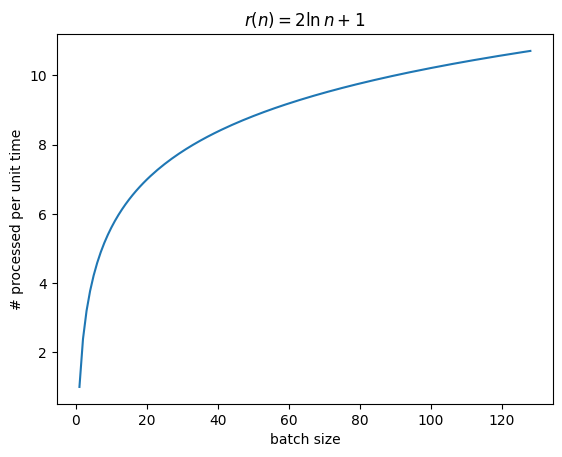

In [2]:
N = 128
a = 2
b = 1

batch_sizes = np.array(range(1, N+1))
num_processed_per_sec = a * np.log(batch_sizes) + b

plt.plot(batch_sizes, num_processed_per_sec)
plt.xlabel('batch size')
plt.ylabel('# processed per unit time')
plt.title(f'$r(n) = {a}\ln n + {b}$');

For $n \geq 2$ minimizing average latency per request means solving:

$$
\begin{equation*}
\min_{n \in \{2, 3, \dots, N\} } \:\: \underbrace{ \mathbb{E} \Bigg( \frac{1}{n} \sum_{i=1}^{n} T_n - T_i
\Bigg) }_{\text{expected time spent waiting per request}} + \overbrace{ \frac{n}{r(n)}
}^{\text{processing time of batch}}
\end{equation*}
$$

Let's simplify the objective—in particular, simplify the expectation.

First, note that $\mathbb{E} ( T_n - T_i ) = (n-i)\tau$. This fact can be proven
using weak induction: $T_k - T_i = (T_k - T_{k-1}) + (T_{k-1} - T_i)$.

Applying linearity of expectation:

$$
\begin{align*}
\mathbb{E} \Bigg( \frac{1}{n} \sum_{i=1}^{n} T_n - T_i
\Bigg) &= \frac{1}{n} \sum_{i=1}^{n} \mathbb{E} ( T_n - T_i ) \\
&= \frac{1}{n} \sum_{i=1}^{n} (n-i)\tau \\
&= \tau \bigg( \frac{n-1}{2} \bigg).
\end{align*}
$$

The objective is strictly convex on $(0, \infty)$:
* the expected time spent waiting per request is linear
* the processing time is the strictly convex
* these two functions are summed.

So there's a unique minimum somewhere in $(0, \infty)$. That means we can treat this
discrete optimization problem as a continuous one. We'll just have to do some basic
post-processing to get a solution in $\{2, 3, \dots, N\}$.

Call the objective function $t(n)$, i.e., the average latency per request:

$$
\begin{equation*}
t(n) = \tau \bigg( \frac{n-1}{2} \bigg) + \frac{n}{a \ln n + b}
\end{equation*}
$$

Now for the baseline of no batching, i.e., $n = 1$.

Let $F_i$ be the random variable for the time when we've finished processing a user's
request.
Call $t = 1/r(1)$ be the time it takes to process a single request. Then:

$$
F_1 = T_1 + t.
$$

Processing the next request can only commence right after the previous request has
finished processing. (Embarrassingly, I neglected this fact in the first version of this
notebook lol.) So every future request's finishing time is given by the recurrence:

$$
F_i = \underbrace{T_i}_{\text{start time}}
+ \underbrace{\max( F_{i-1} - T_i, 0 )}_{\substack{\text{time spent waiting for the} 
\\ \text{previous request to finish}}}
+ \underbrace{t}_{\substack{\text{time to process}
\\ \text{this one request}}}
$$

Latency for each request is then:

$$
L_i = F_i - T_i.
$$

For a sequence of $m$ total requests, the average latency is:

$$
\frac{1}{m} \sum_{i=1}^{m} L_i.
$$

I think it makes sense to define $t(1)$ as a number which doesn't depend on $m$. So take
the expectation of the average latency in the limit of the number of total requests,
$m$:

$$
t(1) = \mathbb{E} \Bigg( \lim_{m \to \infty} \frac{1}{m} \sum_{i=1}^{m} L_i \Bigg).
$$

In other words, $t(1)$ is the average latency per user over the lifetime of the service.
After I solve $t(1)$, $t$ will be fully defined and specified over $\{1, 2, \dots, N\}$.

TODO: may need
* https://math.stackexchange.com/a/275016
* https://math.stackexchange.com/a/3451394
* https://stats.stackexchange.com/a/53113/337906
* https://math.stackexchange.com/questions/2169833/conditional-expectation-of-x-given-x-is-greater-than-y

# Solution

For $n \geq 2$, set the derivative to 0 and solve for $n$. The solution is:

$$
\begin{equation*}
n^* = \exp \bigg\{ \frac{-1 + \sqrt{1 + 2 \tau a}}{\tau a} - \frac{b}{a} \bigg\}.
\end{equation*}
$$

Here's the quick post-processing rule to get the optimal solution $n' \in \{1, 2, \dots,
N\}$, which makes use of the fact that $t(n)$ is strictly convex:

$$
n' = \begin{cases} 
   1 & 0 < n^* \leq 1 \\
   \text{arg min}_{n \in \{ \lfloor n^* \rfloor, \lceil n^* \rceil \}} \: t(n) & 1 < n^* \leq N \\
   N & n^* > N 
\end{cases}
$$

Either we batch or we don't batch. The solution is the minimum of these two:

$$
\text{arg min}_{n \in \{ 1, n' \}} \: t(n)
$$

See [this desmos graph](https://www.desmos.com/calculator/ez9qpo0ll3) to explore.

# Implementation

**TODO**: this code doesn't yet implement that last argmin rule above, b/c I need to
compute $t(1)$.

First, implement some batch size calculators: one for a linear rate and one for a log
rate.

In [3]:
# helpers. see next cell for calculators
def _average_latency(
    func: Callable,
    average_inter_arrival_time: float,
    slope: float,
    intercept: float,
    batch_size: int,
):
    average_waiting_time = average_inter_arrival_time * ((batch_size - 1) / 2)
    processing_time = batch_size / (slope * func(batch_size) + intercept)
    return average_waiting_time + processing_time


def _post_process(
    func: Callable,
    average_inter_arrival_time: float,
    slope: float,
    intercept: float,
    batch_size_optimal: int,
    max_batch_size: int,
):
    # post-process batch_size_optimal to get an integer in [1, max_batch_size]
    if batch_size_optimal <= 1:
        return 1
    elif batch_size_optimal <= max_batch_size:
        batch_size_optimal_floor = int(np.floor(batch_size_optimal))
        batch_size_optimal_ceil = int(np.ceil(batch_size_optimal))
        average_latency = partial(
            _average_latency,
            func,
            average_inter_arrival_time,
            slope,
            intercept,
        )
        if average_latency(batch_size_optimal_floor) < average_latency(
            batch_size_optimal_ceil
        ):
            return batch_size_optimal_floor
        else:
            return batch_size_optimal_ceil
    else:
        return max_batch_size


def _optimal_batch_size(
    func: Callable,
    batch_size_optimal_func: Callable,
    average_inter_arrival_time: float,
    slope: float,
    intercept: float,
    max_batch_size: int,
) -> int:
    # input checks
    if not average_inter_arrival_time > 0:
        raise ValueError("average_inter_arrival_time must be positive.")
    if not slope > 0:
        raise ValueError("slope must be positive.")

    # calculate n*
    batch_size_optimal = batch_size_optimal_func(
        average_inter_arrival_time=average_inter_arrival_time,
        slope=slope,
        intercept=intercept,
    )

    # post-process to get an integer in [1, max_batch_size]
    return _post_process(
        func,
        average_inter_arrival_time,
        slope,
        intercept,
        batch_size_optimal,
        max_batch_size,
    )

In [4]:
def optimal_batch_size_linear(
    average_inter_arrival_time: float,
    slope: float,
    intercept: float,
    max_batch_size: int,
) -> int:
    """
    Calculates the batch size which minimizes average latency of a streaming
    application, assuming that the processing rate (# inputs processed per unit time) of
    the application has linear growth wrt batch size.

    Parameters
    ----------
    average_inter_arrival_time : float
        Average time between requests.
    slope : float
        Slope of linear growth rate equation.
    intercept : float
        Intercept of linear growth rate equation.
    max_batch_size : int
        Maximum batch size that the application can handle, typically due to memory
        constraints. Can be set to ``math.inf`` if there's no limit.

    Returns
    -------
    int
        Optimal batch size

    Raises
    ------
    ValueError
        if `average_inter_arrival_time` is not positive.
    ValueError
        if `slope` is not positive.
    """

    def batch_size_optimal_func(average_inter_arrival_time, slope, intercept):
        # for convenience, short variable names which match math
        _tau = average_inter_arrival_time
        _a = slope
        _2a = 2 * _a
        _b = intercept

        raise NotImplementedError

    return _optimal_batch_size(
        lambda x: x,
        batch_size_optimal_func,
        average_inter_arrival_time,
        slope,
        intercept,
        max_batch_size,
    )


def optimal_batch_size_log(
    average_inter_arrival_time: float,
    slope: float,
    intercept: float,
    max_batch_size: int,
) -> int:
    """
    Calculates the batch size which minimizes average latency of a streaming
    application, assuming that the processing rate (# inputs processed per unit time) of
    the application has logarithmic growth wrt batch size.

    Parameters
    ----------
    average_inter_arrival_time : float
        Average time between requests.
    slope : float
        Slope of logarithmic growth rate equation.
    intercept : float
        Intercept of logarithmic growth rate equation.
    max_batch_size : int
        Maximum batch size that the application can handle, typically due to memory
        constraints. Can be set to ``math.inf`` if there's no limit.

    Returns
    -------
    int
        Optimal batch size

    Raises
    ------
    ValueError
        if `average_inter_arrival_time` is not positive.
    ValueError
        if `slope` is not positive.
    """

    def batch_size_optimal_func(average_inter_arrival_time, slope, intercept):
        # for convenience, short variable names which match math
        _tau = average_inter_arrival_time
        _a = slope
        _2a = 2 * _a
        _b = intercept

        return np.exp(((-1 + np.sqrt(1 + 2 * _tau * _a)) / (_tau * _a)) - (_b / _a))

    return _optimal_batch_size(
        np.log,
        batch_size_optimal_func,
        average_inter_arrival_time,
        slope,
        intercept,
        max_batch_size,
    )


# may be useful. TODO: document these
average_latency_log = partial(_average_latency, np.log)
average_latency_linear = partial(_average_latency, lambda x: x)

And here's an implementation of waiting and batching:

In [6]:
def batch_requests(
    stream: Generator, batch_size: int, max_delay_sec: float
) -> Generator:
    """
    Converts a stream of single inputs into a stream of batched inputs by waiting in
    between inputs.

    Parameters
    ----------
    stream : Generator
        Stream of single inputs
    batch_size : int
        Maximum number of inputs in each batch.
    max_delay_sec : float
        Maximum time to wait before generating a batch. If the time since receiving the
        first input in the batch exceeds `max_delay_sec`, then the batch is generated
        despite having fewer than `batch_size` inputs. Set this to ``math.inf`` to
        guarantee that every generated batch has size `batch_size`.

    Yields
    ------
    list
        batched inputs.
    """
    batch = []
    start_time = time.time()

    for obj in stream:
        batch.append(obj)
        time_since_first_obj_in_batch_received = time.time() - start_time

        if (
            len(batch) == batch_size
            or time_since_first_obj_in_batch_received >= max_delay_sec
        ):
            yield batch
            batch = []
            start_time = time.time()

    # there are ungenerated objects from the last batch if neither condition was met
    if batch:
        yield batch

Quick test:

In [7]:
def test(
    batch_size: int,
    max_delay_sec: float,
    num_requests: int,
    sleep_every: int,
    sleep_sec: float,
):
    # create stream
    is_sleeping = lambda i: i > 0 and i % sleep_every == 0

    def fake_stream():
        for i in range(num_requests):
            if is_sleeping(i):
                time.sleep(sleep_sec)
            yield i

    # expected result
    expected_batches = []
    batch = []
    for i in fake_stream():
        batch.append(i)
        if len(batch) == batch_size or is_sleeping(i):
            expected_batches.append(batch)
            batch = []
    if batch:
        expected_batches.append(batch)

    # observed result
    observed_batches = []
    for batch in batch_requests(fake_stream(), batch_size, max_delay_sec):
        observed_batches.append(batch)

    assert observed_batches == expected_batches

In [8]:
test(batch_size=3, max_delay_sec=0.1, num_requests=10, sleep_every=4, sleep_sec=0.5)

# Example

TODO: broken

Say we're running a text generation service. Running the [GPT-2 demo
notebook](https://github.com/kddubey/stackexchange/blob/main/to_batch_or_not_to_batch/demo_gpt2.ipynb)
on a V100 GPU produces these 2 fits (for the notebook's fake/dumb generation service):

![](./gpt2_batch.png)

The linear fit is a bit better for smaller batch sizes. I'd go with that, but I've made
a systematic error.

Play w/ the [desmos graph here](https://www.desmos.com/calculator/xdg4ubzoch).

In [9]:
optimal_batch_size_log(
    average_inter_arrival_time=0.1,
    slope=0.41,
    intercept=-0.02,
    max_batch_size=50
)

7

TODO: re-simulate to verify the speedup.